In [14]:
import numpy as np
from neural_network_dynamics import main as ntwk
from datavyz import nrnvyz
from datavyz import gedn as ge
from IPython.display import Image

from model import Model
# np.savez('study.npz', **Model)

# NMDA activation threshold

## Batch simulation

In [20]:
# 
import numpy as np
import os
from analyz.workflow.batch_run import GridSimulation, bash_script

GRID = {'qNMDA':np.array([0,0.5]),
        'Deltax0':np.array([0, 0.5]),
        'Fexc_bg':np.array([0, 2., 5., 7.]),
        'seed':np.arange(20),
        'branch_index':np.arange(27)}

np.savez(os.path.join('data', 'syn-input', 'spike-threshold-grid.npz'), **GRID)
sim = GridSimulation(GRID)
bs = bash_script('syn-input-threshold')
bs.script = sim.build_script('python spike_threshold.py syn-input',
                             base_script=bs.script, simultaneous_runs=3*8)
bs.write(folder='./bash/')


## Building the set of segments corresponding to individual branches

In [337]:
from spike_threshold import compute_branches_for_stimuli
morpho = ntwk.Morphology.from_swc_file(Model['morpho_file_1'])
SEGMENTS = ntwk.morpho_analysis.compute_segments(morpho)
nseg = len(SEGMENTS['x'])
segments_of_branches = compute_branches_for_stimuli(SEGMENTS)

In [493]:
from datavyz import ge

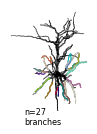

In [638]:
vis = nrnvyz(SEGMENTS, ge=ge)
branch_colors = [ge.colors[int(5+i)] for i in range(len(segments_of_branches))]
fig1, ax= vis.plot_segments(SEGMENTS['comp_type']!='axon', bar_scale_args={},
                            fig_args=dict(figsize=(1.5,2.4), left=0, bottom=0, top=0, right=0))
for d, sb in enumerate(segments_of_branches):
    vis.plot_segments(sb, color=branch_colors[d], ax=ax, bar_scale_args={})
ge.annotate(ax, 'n=%i\nbranches' % (d+1), (0.2,-.1))

In [507]:
import numpy as np
import os
from analyz.workflow.batch_run import GridSimulation, bash_script
from model import Model
# load the above simulation grid
sim = GridSimulation(os.path.join('data', 'syn-input', 'spike-threshold-grid.npz'))
Nsyn_array = np.logspace(np.log10(Model['ISIB_Nsyn1']), np.log10(Model['ISIB_Nsyn2']),
                         Model['ISIB_Nsyn_N'], dtype=int)
setattr(sim, 'Nsyn_array', Nsyn_array)


In [508]:
# build Responses
import itertools
from analyz.IO.npz import load_dict
from analyz.optimization.fits import curve_fit

RESPONSES = {}
for cond, iqNMDA, iDeltax0 in zip(['AMPA-only', 'AMPA+NMDA-chelat-zinc', 'AMPA+NMDA-free-zinc'],
                                  [0, 1, 1], [0, 0, 1]):

    RESPONSES[cond] = np.zeros((len(sim.Nsyn_array), len(sim.GRID['branch_index']),
                           int((Model['ISIB_window']+Model['ISIB_before'])/Model['dt'])))
    RESPONSES[cond+'-with-noise'] = np.zeros((len(sim.GRID['Fexc_bg'])-1, len(sim.GRID['seed']),
                                              len(sim.Nsyn_array), len(sim.GRID['branch_index']),
                           int((Model['ISIB_window']+Model['ISIB_before'])/Model['dt'])))

    for ibranch, branch_index in enumerate(sim.GRID['branch_index']):

        ## --- NO NOISE ---
        fn = os.path.join('data', 'syn-input', sim.params_filename([iqNMDA, iDeltax0, 0, 0, ibranch])+'.npz')
        if os.path.isfile(fn):
            data = load_dict(fn)
            for k in range(Model['ISIB_Nsyn_N']):
                t0 = Model['ISIB_delay']+k*Model['ISIB_window']
                tcond = (data['t']>=t0-Model['ISIB_before']) & (data['t']<t0+Model['ISIB_window'])
                RESPONSES[cond][k, ibranch, :] = data['v'][tcond]
        else:
            print(fn, 'missing !')
            
        ## --- WITH NOISE ---
        for ifreq, iseed in itertools.product(range(len(sim.GRID['Fexc_bg'])-1), range(len(sim.GRID['seed']))):
            fn = os.path.join('data', 'syn-input',
                              sim.params_filename([iqNMDA,iDeltax0,ifreq+1,iseed,ibranch])+'.npz')
            if os.path.isfile(fn):
                data = load_dict(fn)
                for k in range(Model['ISIB_Nsyn_N']):
                    t0 = Model['ISIB_delay']+k*Model['ISIB_window']
                    tcond = (data['t']>=t0-Model['ISIB_before']) & (data['t']<t0+Model['ISIB_window'])
                    RESPONSES[cond+'-with-noise'][ifreq, iseed, k, ibranch, :] = data['v'][tcond]
RESPONSES['t'] = data['t'][tcond]-t0
    

In [509]:
# make fits
FITS = {}
from analyz.optimization.fits import curve_fit
# waveform
def waveform(t, coeffs=[-70, 1, 10, 20, 20]):
    A0, A1, T1, T2, t2  = coeffs
    return A0+A1*heaviside(t-1)*(1-np.exp(-t/T1)-error((t-t2)/T2)) # -1 in heaviside so that H(0)=0 (H(0)=0.5 makes a discontinuity)

tcond = (RESPONSES['t']>-50)
t = RESPONSES['t'][tcond]

for cond in ['AMPA-only', 'AMPA+NMDA-chelat-zinc', 'AMPA+NMDA-free-zinc']:

    FITS[cond] = np.zeros((len(sim.Nsyn_array), len(sim.GRID['branch_index']), 5))
    FITS[cond+'-with-noise'] = np.zeros((len(sim.GRID['Fexc_bg'])-1,
                                         len(sim.Nsyn_array), len(sim.GRID['branch_index']),5))

    for ibranch, branch_index in enumerate(sim.GRID['branch_index']):
        
        ## --- NO NOISE ---
        for k in range(Model['ISIB_Nsyn_N']):
            FITS[cond][k, ibranch, :] = curve_fit(RESPONSES['t'], RESPONSES[cond][k, ibranch, :],
                                                  waveform,
                        bounds=[(-75, -50), (0.01, 15), (1,50), (10, 300), (0, 200)]).x
            
            ## --- WITH NOISE ---
            for ifreq in range(len(sim.GRID['Fexc_bg'])-1):
                FITS[cond+'-with-noise'][ifreq, k, ibranch, :] = curve_fit(RESPONSES['t'],
                        RESPONSES[cond+'-with-noise'][ifreq, :, k, ibranch, :].mean(axis=0),
                        waveform,
                        bounds=[(-75, -50), (0.01, 15), (1,50), (10, 300), (0, 200)]).x

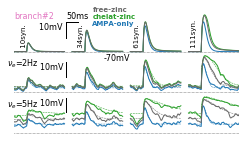

In [642]:
fig2, AX = ge.figure(axes=(1,3), figsize=(1.9,.9), hspace=0, bottom=0, left=0)

NSYNS, NFREQS = [4, 6, 7, 8], [0,1]
TSHIFT = 30
ibranch = 1
TVIEW = [-50, 150]
tcond = (RESPONSES['t']>TVIEW[0]) & (RESPONSES['t']<TVIEW[1])

for i, nsyn in enumerate(NSYNS):
    for cond, c in zip(['AMPA-only', 'AMPA+NMDA-chelat-zinc', 'AMPA+NMDA-free-zinc'],
                       [ge.blue, ge.green, ge.dimgrey]):
        # no noise
        AX[0].plot(RESPONSES['t'][tcond]+i*(TVIEW[1]-TVIEW[0]+TSHIFT),
                   RESPONSES[cond][nsyn, ibranch, tcond], color=c, lw=1)

        # with noise
        for iax, ifreq, iseed in zip([1,2], NFREQS, [0,0]):
            # fit first
            AX[iax].plot(RESPONSES['t'][tcond]+i*(TVIEW[1]-TVIEW[0]+TSHIFT),
                         waveform(RESPONSES['t'][tcond], FITS[cond+'-with-noise'][ifreq, nsyn, ibranch, :]),
                         color=c, lw=0.5, ls='--')
            AX[iax].plot(RESPONSES['t'][tcond]+i*(TVIEW[1]-TVIEW[0]+TSHIFT),
                      RESPONSES[cond+'-with-noise'][ifreq, iseed, nsyn, ibranch, tcond],color=c,lw=1)
    ge.annotate(AX[0], ' %isyn.'% sim.Nsyn_array[nsyn],
                (i*(TVIEW[1]-TVIEW[0]+TSHIFT-5), Model['EL']+1),
                xycoords='data', size='small', rotation=90, ha='right')
ge.annotate(AX[0], 'branch#%i' % (ibranch+1), (.0,.8), color=branch_colors[ibranch])
ge.annotate(AX[1], '%.0fmV' % Model['EL'], (.4,.99), va='top')
ge.draw_bar_scales(AX[0], Xbar=50, Xbar_label='50ms', Ybar=10, Ybar_label='10mV ',
                   loc='top-left',xyLoc=(155,-52))
ge.draw_bar_scales(AX[1], Ybar=10, Ybar_label='10mV ', loc='top-left',xyLoc=(155,-50))
ge.draw_bar_scales(AX[2], Ybar=10, Ybar_label='10mV ', loc='top-left',xyLoc=(155,-45))
for ax in AX:
    ge.plot([TVIEW[0],TVIEW[0]+i*TSHIFT+(i+1)*(TVIEW[1]-TVIEW[0])], Model['EL']*np.ones(2),
            ls=':',lw=0.5, ax=ax,no_set=True)
    ge.set_plot(ax, [], xlim=[TVIEW[0], TVIEW[0]+i*TSHIFT+(i+1)*(TVIEW[1]-TVIEW[0])])
for iax, ifreq, iseed in zip([1,2], NFREQS, [0,0]):
    ge.annotate(AX[iax],'$\\nu_{e}$=%.0fHz'%sim.GRID['Fexc_bg'][ifreq+1],(-0.03,0.6))

for cond, c, ic in zip(['AMPA-only', 'chelat-zinc', 'free-zinc'],
                       [ge.blue, ge.green, ge.dimgrey], range(3)):
    ge.annotate(AX[0], cond+ic*'\n', (260,Model['EL']+15), color=c, size='small', xycoords='data', bold=True)
    

In [601]:
# compute area

AREAS, PROBAS, THRESH = {}, {}, {}
THRESHOLD_FACTOR = 1.25
for cond in ['AMPA-only', 'AMPA+NMDA-chelat-zinc', 'AMPA+NMDA-free-zinc']:

    AREAS[cond] = np.zeros((len(sim.Nsyn_array), len(sim.GRID['branch_index'])))
    AREAS[cond+'-with-noise'] = np.zeros((len(sim.GRID['Fexc_bg'])-1,
                                         len(sim.Nsyn_array), len(sim.GRID['branch_index'])))
    PROBAS[cond] = np.ones((len(sim.Nsyn_array), len(sim.GRID['branch_index'])))
    PROBAS[cond+'-with-noise'] = np.ones((len(sim.GRID['Fexc_bg'])-1,
                                          len(sim.Nsyn_array), len(sim.GRID['branch_index'])))
    THRESH[cond] = np.zeros((len(sim.GRID['branch_index']),2))
    THRESH[cond+'-with-noise'] = np.zeros((len(sim.GRID['Fexc_bg'])-1, len(sim.GRID['branch_index']),2))


    for ibranch, branch_index in enumerate(sim.GRID['branch_index']):
        
        ## --- NO NOISE ---
        for k in range(Model['ISIB_Nsyn_N']):
            dv = waveform(RESPONSES['t'], FITS[cond][k, ibranch, :])-FITS[cond][k, ibranch, 0]
            AREAS[cond][k, ibranch] = np.trapz(dv, RESPONSES['t'])
        if cond!='AMPA-only':
            iis = np.argwhere(AREAS[cond][:, ibranch]<=THRESHOLD_FACTOR*AREAS['AMPA-only'][:, ibranch]).flatten()
            if len(iis)>0:
                PROBAS[cond][:iis[-1], ibranch] = 0
                THRESH[cond][ibranch,:] = [sim.Nsyn_array[iis[-1]], AREAS[cond][iis[-1], ibranch]]
            
        for k in range(Model['ISIB_Nsyn_N']):
            ## --- WITH NOISE ---
            for ifreq in range(len(sim.GRID['Fexc_bg'])-1):
                dv = waveform(RESPONSES['t'], FITS[cond+'-with-noise'][ifreq, k, ibranch, :])-\
                    FITS[cond+'-with-noise'][ifreq, k, ibranch, 0]
                AREAS[cond+'-with-noise'][ifreq, k, ibranch] = np.trapz(dv, RESPONSES['t'])

        for ifreq in range(len(sim.GRID['Fexc_bg'])-1):
            if cond!='AMPA-only':
                iis = np.argwhere(AREAS[cond+'-with-noise'][ifreq, :, ibranch]<=THRESHOLD_FACTOR*AREAS['AMPA-only-with-noise'][ifreq, :, ibranch]).flatten()
                if len(iis)>0:
                    PROBAS[cond+'-with-noise'][ifreq, :iis[-1], ibranch] = 0
                    THRESH[cond+'-with-noise'][ifreq,ibranch,:] = [sim.Nsyn_array[iis[-1]], AREAS[cond+'-with-noise'][ifreq, iis[-1], ibranch]]
                        

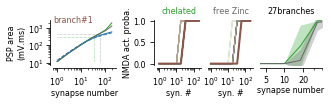

In [622]:


def make_fig_nmda_threshold(AREAS, PROBAS, sim, ibranch=2, ifreq=-1,
                            ax1_args={},#dict(yscale='log', xscale='log'),
                            ax2_args=dict(xscale='log', yticks=[0, 0.5,1], xlabel='syn. #', ylim=[-0.03, 1.03]),
                            ax4_args={}):
    
    fig, [ax1, axnull, ax2, ax3, ax4] = ge.figure(axes_extents=[[[4,1],[2,1],[3,1],[3,1],[4,1]]], figsize=(.3,1.), wspace=1.)
    axnull.axis('off')
    for cond, c in zip(['AMPA-only', 'AMPA+NMDA-chelat-zinc', 'AMPA+NMDA-free-zinc'],
                       [ge.blue, ge.green, ge.dimgrey]):
        if ifreq>=0:
            cond += '-with-noise'
            ge.plot(sim.Nsyn_array, AREAS[cond][ifreq, :,ibranch], ax=ax1, no_set=True, color=c)
            if c!=ge.blue:
                ge.plot(sim.Nsyn_array, PROBAS[cond][ifreq,:,:].mean(axis=-1), sy=PROBAS[cond][ifreq,:,:].std(axis=-1), ax=ax4, no_set=True, color=c)
                ge.plot([sim.Nsyn_array[0], THRESH[cond][ifreq,ibranch,0], THRESH[cond][ifreq,ibranch,0]],
                        [THRESH[cond][ifreq,ibranch,1], THRESH[cond][ifreq,ibranch,1], np.min(AREAS[cond][ifreq, :,ibranch])], ax=ax1, no_set=True, color=c, lw=0.5, ls=':')
        else:
            ge.plot(sim.Nsyn_array, AREAS[cond][:,ibranch], ax=ax1, no_set=True, color=c)
            if c!=ge.blue:
                ge.plot(sim.Nsyn_array, PROBAS[cond].mean(axis=1), sy=PROBAS[cond].std(axis=1), ax=ax4, no_set=True, color=c)
                ge.plot([sim.Nsyn_array[0], THRESH[cond][ibranch,0], THRESH[cond][ibranch,0]],
                        [THRESH[cond][ibranch,1], THRESH[cond][ibranch,1], np.min(AREAS[cond][:,ibranch])], ax=ax1, no_set=True, color=c, lw=0.5, ls=':')
    
    for cond, c, ax in zip(['AMPA+NMDA-chelat-zinc', 'AMPA+NMDA-free-zinc'],
                           [ge.green, ge.dimgrey], [ax2, ax3]):
        for ib in sim.GRID['branch_index']:
            if ifreq>=0:
                ge.plot(sim.Nsyn_array, PROBAS[cond+'-with-noise'][ifreq,:,ib], ax=ax, no_set=True, color=branch_colors[ib])
            else:
                ge.plot(sim.Nsyn_array, PROBAS[cond][:,ib], ax=ax, no_set=True, color=branch_colors[ib])
        if ifreq>=0:
            ge.plot(sim.Nsyn_array, PROBAS[cond+'-with-noise'][ifreq,:,ibranch], ax=ax, no_set=True, color=branch_colors[ibranch], lw=2)
        else:
            ge.plot(sim.Nsyn_array, PROBAS[cond][:,ibranch], ax=ax, no_set=True, color=branch_colors[ibranch], lw=2)
                
    ge.annotate(ax1, 'branch#%i' % (ibranch+1), (0,.9), color=branch_colors[ibranch])
    ge.plot(sim.Nsyn_array, THRESHOLD_FACTOR*AREAS['AMPA-only'].mean(axis=1), ax=ax1, no_set=True, color=ge.blue, ls='--')
    ge.title(ax2, 'chelated', color=ge.green)
    ge.title(ax3, 'free Zinc', color=ge.dimgray)
    ge.set_plot(ax1, xlabel='synapse number', ylabel='PSP area\n(mV.ms)', **ax1_args)
    ge.set_plot(ax2, ylabel='NMDA act. proba.', **ax2_args)
    ge.set_plot(ax3, ['bottom'], **ax2_args)
    ge.set_plot(ax4, ['bottom'], xlabel='synapse number', yticks=[0, 0.5,1], yticks_labels=[], ylim=[-0.03, 1.03], **ax4_args)
    if ifreq>=0:
        ge.annotate(ax1, '$\\nu_e$=%.0fHz\n%iseeds' % (sim.GRID['Fexc_bg'][ifreq+1], len(sim.GRID['seed'])), (1., 0.), ha='right')
    ge.title(ax4, '%ibranches' % len(sim.GRID['branch_index']))
    return fig

fig3 = make_fig_nmda_threshold(AREAS, PROBAS, sim, 0,
                               ax4_args=dict(xlim=[4, 40], xticks=[5, 10, 20], xticks_labels=['5', '10', '20'], xscale='log'),#xticks=[0, 30, 60]),
                               ax1_args=dict(yscale='log', xscale='log'));

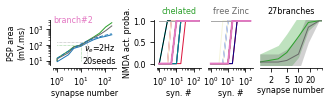

In [623]:
fig4 = make_fig_nmda_threshold(AREAS, PROBAS, sim, 1, 0,
                               ax4_args=dict(xlim=[1, 40], xticks=[2, 5, 10, 20], xticks_labels=['2', '5', '10', '20'], xscale='log'),#xticks=[0, 30, 60]),
                               ax1_args=dict(yscale='log', xscale='log'));

In [648]:
ge.multipanel_figure([[fig1, fig2], [fig3], [fig4]],
                     LABELS=[['a', 'b'], ['c'], ['d']],
                     X_LABELS=[[0, 80], [20], [20]],
                     Y_LABELS=[[0, 0], [150], [250]],
                     X=[[-35, 85], [30], [30]],
                     Y=[[20, 0], [150], [250]],
                     width='one-and-a-half-column',
                     height=130, grid=True,
                     fig_name='figures/fig-model-prediction.png')

RUNNING: inkscape figures/fig-model-prediction.svg --export-area-page --export-background="white" --export-type=png --export-filename="figures/fig-model-prediction.png" --export-dpi=300


[ok] figure successfully exported as: figures/fig-model-prediction.png
[ok] removed figures/fig-model-prediction.svg


# old code

In [18]:
# --------------------------------------
# ----- compute AMPA+NMDA free Zinc ----
# --------------------------------------

AREAS['AMPA+NMDA-free-Zinc'] = np.zeros((len(Nsyn_array), len(GRID['branch_index'])))
PROBA['AMPA+NMDA-free-Zinc'] = np.zeros((len(Nsyn_array), len(GRID['branch_index'])))
AREAS['AMPA+NMDA-free-Zinc-with-noise'] = np.zeros((len(GRID['Fexc_bg'])-1, len(GRID['seed']), len(Nsyn_array), len(GRID['branch_index'])))
PROBA['AMPA+NMDA-free-Zinc-with-noise'] = np.zeros((len(GRID['Fexc_bg'])-1, len(GRID['seed']), len(Nsyn_array), len(GRID['branch_index'])))

for ibranch, branch_index in enumerate(GRID['branch_index']):
    # NO NOISE
    fn = os.path.join('data', 'syn-input', sim.params_filename([1, 1, 0, 0, ibranch])+'.npz')
    if os.path.isfile(fn):
        data, areas = load_dict(fn), []
        for k in range(Model['ISIB_Nsyn_N']):
            AREAS['AMPA+NMDA-free-Zinc'][k, ibranch] = get_area(k, data, Model)
            if AREAS['AMPA+NMDA-free-Zinc'][k, ibranch]>THRESHOLD_FACTOR*AREAS['AMPA-only'][k, ibranch]:
                PROBA['AMPA+NMDA-free-Zinc'][k, ibranch]=1
    else:
        print(fn, 'missing !')
    ## WITH NOISE
    for ifreq, iseed in itertools.product(range(len(GRID['Fexc_bg'])-1), range(len(GRID['seed']))):
        fn = os.path.join('data', 'syn-input', sim.params_filename([1,1,ifreq+1,iseed,ibranch])+'.npz')
        if os.path.isfile(fn):
            data, areas = load_dict(fn), []
            for k in range(Model['ISIB_Nsyn_N']):
                AREAS['AMPA+NMDA-free-Zinc-with-noise'][ifreq, iseed, k, ibranch] = get_area(k, data, Model)
                if AREAS['AMPA+NMDA-free-Zinc-with-noise'][ifreq, iseed, k, ibranch]>THRESHOLD_FACTOR*AREAS['AMPA-only-with-noise'][ifreq, iseed, k, ibranch]:
                    PROBA['AMPA+NMDA-free-Zinc-with-noise'][ifreq, iseed, k, ibranch]=1
        else:
            print(fn, 'missing !')

            

NameError: name 'Nsyn_array' is not defined

In [12]:
fig, [ax, ax2] = ge.figure(axes=(2,1))#figsize=(1.3,1.3))

Nsyn_array = np.logspace(np.log10(Model['ISIB_Nsyn1']), np.log10(Model['ISIB_Nsyn2']),
                         Model['ISIB_Nsyn_N'], dtype=int)

AREAS = {}
for cond, color in zip(['AMPA-NMDA', 'AMPA-NMDA-chZn', 'oAMPA'], [ge.r, ge.b, ge.green]):
    areas = []
    for k in range(Model['ISIB_Nsyn_N']):
        t0 = Model['ISIB_delay']+k*Model['ISIB_window']
        tcond = (MDATA['t']>t0) & (MDATA['t']<t0+Model['ISIB_window'])

        

In [2]:
from datavyz import ge

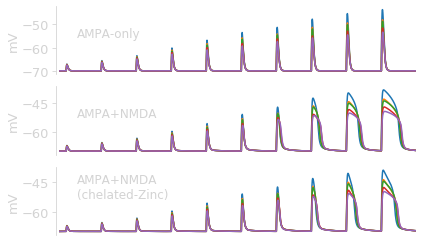

In [7]:
from analyz.IO.npz import load_dict

fig, AX = ge.figure(axes=(1, 3), figsize=(1.5, .6), hspace=0.3)
sim = GridSimulation(os.path.join('data', 'syn-input', 'spike-threshold-grid.npz'))
params, MDATA = {}, {'oAMPA':[], 'AMPA-NMDA':[], 'AMPA-NMDA-chZn':[]}
for index in range(sim.N):
    sim.update_dict_from_GRID_and_index(index, params) # update Model parameters
    data = load_dict(os.path.join('data', 'syn-input', sim.params_filename(index)+'.npz'))
    if (params['qNMDA']==0) and (params['Deltax0']==0):
        AX[0].plot(data['t'], data['v'], color=ge.colors[params['branch_index']%10])
        MDATA['oAMPA'].append(data['v'])
    elif (params['qNMDA']>0) and (params['Deltax0']==0):
        AX[1].plot(data['t'], data['v'], color=ge.colors[params['branch_index']%10])
        MDATA['AMPA-NMDA'].append(data['v'])
    elif (params['qNMDA']>0) and (params['Deltax0']>0):
        AX[2].plot(data['t'], data['v'], color=ge.colors[params['branch_index']%10])
        MDATA['AMPA-NMDA-chZn'].append(data['v'])
MDATA['t'] = data['t']
for ax, label in zip(AX, ['AMPA-only', 'AMPA+NMDA', 'AMPA+NMDA\n(chelated-Zinc)']):
    ge.annotate(ax, label, (0.05, .5), size='small')
    ge.set_plot(ax, ['left'], ylabel='mV', xlim=[data['t'][0], data['t'][-1]])

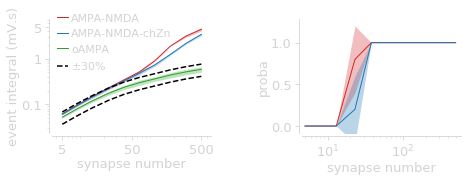

In [131]:
from model import Model

fig, [ax, ax2] = ge.figure(axes=(2,1))#figsize=(1.3,1.3))

Nsyn_array = np.logspace(np.log10(Model['ISIB_Nsyn1']), np.log10(Model['ISIB_Nsyn2']),
                         Model['ISIB_Nsyn_N'], dtype=int)

AREAS = {}
for cond, color in zip(['AMPA-NMDA', 'AMPA-NMDA-chZn', 'oAMPA'], [ge.r, ge.b, ge.green]):
    areas = []
    for k in range(Model['ISIB_Nsyn_N']):
        t0 = Model['ISIB_delay']+k*Model['ISIB_window']
        tcond = (MDATA['t']>t0) & (MDATA['t']<t0+Model['ISIB_window'])
        areas.append([])
        for v in MDATA[cond]:
            areas[-1].append((np.mean(v[tcond])-Model['EL'])*Model['ISIB_window']*1e-3)
    AREAS[cond] = np.array(areas)
    ge.plot(Nsyn_array, np.mean(AREAS[cond], axis=1),
            sy=np.std(AREAS[cond], axis=1),
            color=color, label=cond, ax=ax, no_set=True)
    if cond=='oAMPA':
        ax.plot(Nsyn_array, 0.7*np.mean(AREAS[cond], axis=1), 'k--')
        ax.plot(Nsyn_array, 1.3*np.mean(AREAS[cond], axis=1), 'k--', label='$\pm$30%')

FACTOR = 1.3
for cond, color in zip(['AMPA-NMDA', 'AMPA-NMDA-chZn'], [ge.r, ge.b, ge.green]):
    activation_data = np.zeros((Model['ISIB_Nsyn_N'], AREAS['oAMPA'].shape[1]))
    for i in range(AREAS['oAMPA'].shape[1]):
        for k in range(Model['ISIB_Nsyn_N']):
            if AREAS[cond][k, i]>FACTOR*AREAS['oAMPA'][k, i]:
                activation_data[k, i] = 1.
            else:
                activation_data[k, i] = 0
    
    ge.plot(Nsyn_array, np.mean(activation_data,axis=1),
            sy = np.std(activation_data,axis=1),
            color=color, ax=ax2)
        
ge.legend(ax, size='x-small', loc=(0.,0.5))
ge.set_plot(ax, xscale='log',
            ylabel='event integral (mV.s)', xlabel='synapse number',
            yscale='log',
            yticks=[0.1, 1, 5],
            yticks_labels=['0.1', '1', '5'],
            xticks=[5, 50, 500],
            xticks_labels=['5', '50', '500'])

ge.set_plot(ax2, xscale='log',
            # yscale='log',
            # xlim=[7,100],
            yticks=[0., 0.5, 1],
            # xticks=[5, 50, 500],
            # xticks_labels=['5', '50', '500'],
            ylabel='proba', xlabel='synapse number')

# NMDA spike threshold

In [7]:
morpho = ntwk.Morphology.from_swc_file(Model['morpho_file_1'])
SEGMENTS = ntwk.morpho_analysis.compute_segments(morpho)
nseg = len(SEGMENTS['x'])

basal_cond = ntwk.morpho_analysis.find_conditions(SEGMENTS,
                                            comp_type='dend',
                                            min_distance_to_soma=20e-6)
prox_cond = ntwk.morpho_analysis.find_conditions(SEGMENTS,
                                                 comp_type=['dend', 'soma'],
                                                 max_distance_to_soma=20e-6)

# spreading synapses for bg noise

Nsyn_Glut,\
    pre_to_iseg_Glut,\
    Nsyn_per_seg_Glut = ntwk.spread_synapses_on_morpho(SEGMENTS,
                                                       4,
                                                       cond=basal_cond,
                                                       density_factor=1./100./1e-12)

Nsyn_GABAprox,\
    pre_to_iseg_GABAprox,\
    Nsyn_per_seg_GABAprox = ntwk.spread_synapses_on_morpho(SEGMENTS,
                                                           2,
                                                           cond=prox_cond,
                                                           density_factor=1./100./1e-12)

Nsyn_GABAdist,\
    pre_to_iseg_GABAdist,\
    Nsyn_per_seg_GABAdist = ntwk.spread_synapses_on_morpho(SEGMENTS,
                                                           1,
                                                           cond=basal_cond,
                                                           density_factor=1./100./1e-12)
Nsyn_GABA = Nsyn_GABAdist+Nsyn_GABAprox
Nsyn_per_seg_GABA = Nsyn_per_seg_GABAdist+Nsyn_per_seg_GABAprox
pre_to_iseg_GABA = np.concatenate([pre_to_iseg_GABAprox,
                                   len(pre_to_iseg_GABAprox)+pre_to_iseg_GABAdist])


Spreading 366 synapses over the segments
Spreading 59 synapses over the segments
Spreading 91 synapses over the segments


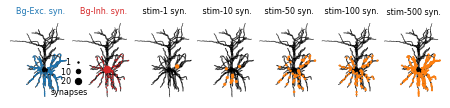

In [8]:
from datavyz import ge

n0 = 20

fig1, AX = ge.figure(axes_extents=[[[1,2] for i in range(7)]],
                     wspace=0., top=0.1, left=0)
vis = nrnvyz(SEGMENTS, ge=ge)

marker_size_factor = 2.
# excitatory

for i, n in enumerate([1, 10, 50, 100, 500]):
    vis.plot_segments(SEGMENTS['comp_type']!='axon', ax=AX[i+2],
                      bar_scale_args={})
    vis.add_dots(AX[i+2], pre_to_iseg_Glut[n0:n0+n], 20/(i+1), ge.orange)
    ge.title(AX[i+2], ' stim-%i syn.' % n)

# synapses of BG
vis.plot_segments(SEGMENTS['comp_type']!='axon', ax=AX[0], bar_scale_args={})
vis.add_dots(AX[0], np.arange(nseg)[Nsyn_per_seg_Glut>0],
             marker_size_factor*Nsyn_per_seg_Glut[Nsyn_per_seg_Glut>0], ge.blue)
ge.title(AX[0], '  Bg-Exc. syn.', color=ge.blue)

vis.plot_segments(SEGMENTS['comp_type']!='axon', ax=AX[1], bar_scale_args={})
vis.add_dots(AX[1], np.arange(nseg)[Nsyn_per_seg_GABA>0],
             marker_size_factor*Nsyn_per_seg_GABA[Nsyn_per_seg_GABA>0], ge.red)
ge.title(AX[1], '  Bg-Inh. syn.', color=ge.red)

for i, x in enumerate([1, 10, 20]):
    xx, yy = -160, 40-i*50
    AX[1].scatter([xx], [yy], s=marker_size_factor*x, color='k')
    ge.annotate(AX[1], str(x)+' ', (xx-20, yy), xycoords='data', ha='right', va='center')
ge.annotate(AX[1], 'synapses', (0, 0.05), ha='center')




In [11]:
from analyz.IO.npz import load_dict
D = load_dict('data/data.npz')

CTRLs = D['CTRLs']
CHELATEDs=D['CHELATEDs']
t, FREQS, NSYN, delay = D['t'], D['FREQS'], D['NSYN'], D['delay']
DT = 300

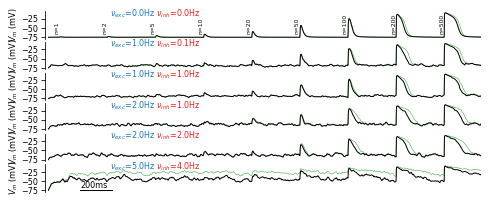

In [5]:
fig2, AX = ge.figure(axes_extents=[[(4,1)] for i in range(len(FREQS))],
                     figsize=(1.1,.6),
                     hspace=0.2, right=0., top=0., bottom=0.)

for i, (fe, fi) in enumerate(FREQS):

    AX[i].plot(t, CHELATEDs[i], color=ge.green, lw=0.5)
    AX[i].plot(t, CTRLs[i], color='k', lw=1)
    ge.set_plot(AX[i], ['left'], ylabel='$V_m$ (mV)', xlim=[0, t[-1]])
    ge.annotate(AX[i], '$\\nu_{exc}$=%.1fHz ' % fe, (0.25,.7), color=ge.blue, ha='right')
    ge.annotate(AX[i], '$\\nu_{inh}$=%.1fHz' % fi, (0.25,.7), color=ge.red, ha='left')
    
for n in range(len(NSYN)):
    ge.annotate(AX[0], 'n=%i' % NSYN[n], (n*DT+delay, -65), rotation=90,
                size='x-small', ha='right', xycoords='data')

AX[-1].plot([200, 400], [-75, -75], 'k-', lw=1)
ge.annotate(AX[-1], '200ms', (200, -75), xycoords='data')


In [123]:
ge.multipanel_figure([[fig1], [fig2]],
                     LABELS=[['a'],['b']],
                     Y_LABELS = [[0],[100]],
                     X_LABELS=[[0], [0]],
                     Y=[[0], [100]],
                     width='double-column',
                     height=100, grid=True,
                     fig_name='figures/fig-model-prediction.png')

RUNNING: inkscape figures/fig-model-prediction.svg --export-area-page --export-background="white" --export-type=png --export-filename="figures/fig-model-prediction.png" --export-dpi=300
[ok] figure successfully exported as: figures/fig-model-prediction.png
[ok] removed figures/fig-model-prediction.svg


# Morphology analysis

In [6]:
morpho = ntwk.Morphology.from_swc_file(Model['morpho_file_1'])
SEGMENTS = ntwk.morpho_analysis.compute_segments(morpho)
nseg = len(SEGMENTS['x'])

## Spreading synapses

marker_size_factor = 0.5
# excitatory 
basal_cond = ntwk.morpho_analysis.find_conditions(SEGMENTS,
                                            comp_type='dend',
                                            min_distance_to_soma=20e-6)
prox_cond = ntwk.morpho_analysis.find_conditions(SEGMENTS,
                                                 comp_type=['dend', 'soma'],
                                                 max_distance_to_soma=20e-6)

Nsyn_GlutL23, pre_to_iseg_GlutL23, Nsyn_per_seg_GlutL23 = ntwk.spread_synapses_on_morpho(SEGMENTS,
                                                                          Model['DensityGlut_L23'],
                                                                          cond=basal_cond,
                                                                          density_factor=1./100./1e-12)

Nsyn_GlutL4, pre_to_iseg_GlutL4, Nsyn_per_seg_GlutL4 = ntwk.spread_synapses_on_morpho(SEGMENTS,
                                                                          Model['DensityGlut_L4'],
                                                                          cond=basal_cond,
                                                                          density_factor=1./100./1e-12)

Nsyn_GABAprox, pre_to_iseg_GABAprox, Nsyn_per_seg_GABAprox = ntwk.spread_synapses_on_morpho(SEGMENTS,
                                                                          Model['DensityGABA_soma'],
                                                                          cond=prox_cond,
                                                                          density_factor=1./100./1e-12)

Nsyn_GABAdist, pre_to_iseg_GABAdist, Nsyn_per_seg_GABAdist = ntwk.spread_synapses_on_morpho(SEGMENTS,
                                                                          Model['DensityGABA_dend'],
                                                                          cond=basal_cond,
                                                                          density_factor=1./100./1e-12)
Nsyn_GABA = Nsyn_GABAdist+Nsyn_GABAprox
Nsyn_per_seg_GABA = Nsyn_per_seg_GABAdist+Nsyn_per_seg_GABAprox
pre_to_iseg_GABA = np.concatenate([pre_to_iseg_GABAprox,
                                   len(pre_to_iseg_GABAprox)+pre_to_iseg_GABAdist])


Spreading 640 synapses over the segments
Spreading 640 synapses over the segments
Spreading 449 synapses over the segments
Spreading 457 synapses over the segments


# Simulations with background activity

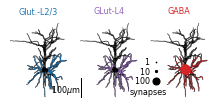

In [7]:

from datavyz import ge
fig1, AX = ge.figure(axes_extents=[[[1,2],[1,2],[1,2]]], wspace=0.2, top=0.1, left=0)

vis = nrnvyz(SEGMENTS, ge=ge)

vis.plot_segments(SEGMENTS['comp_type']!='axon', ax=AX[0],
                  bar_scale_args={})
vis.add_dots(AX[0], np.arange(nseg)[Nsyn_per_seg_GlutL23>0],
             marker_size_factor*Nsyn_per_seg_GlutL23[Nsyn_per_seg_GlutL23>0], ge.blue)
ge.title(AX[0], 'Glut.-L2/3', color=ge.blue)

vis.plot_segments(SEGMENTS['comp_type']!='axon', ax=AX[1])
vis.add_dots(AX[1], np.arange(nseg)[Nsyn_per_seg_GlutL4>0],
             marker_size_factor*Nsyn_per_seg_GlutL4[Nsyn_per_seg_GlutL4>0], ge.purple)
ge.title(AX[1], 'GLut-L4', color=ge.purple)


vis.plot_segments(SEGMENTS['comp_type']!='axon', ax=AX[2], bar_scale_args={})
vis.add_dots(AX[2], np.arange(nseg)[Nsyn_per_seg_GABA>0],
             marker_size_factor*Nsyn_per_seg_GABA[Nsyn_per_seg_GABA>0], ge.red)
ge.title(AX[2], 'GABA', color=ge.red)
for i, x in enumerate([1, 10, 100]):
    xx, yy = -160, 40-i*50
    AX[2].scatter([xx], [yy], s=marker_size_factor*x, color='k')
    ge.annotate(AX[2], str(x)+' ', (xx-20, yy), xycoords='data', ha='right', va='center')
ge.annotate(AX[2], 'synapses', (0, 0.05), ha='center')


In [8]:

from single_cell_sim import EXC_SYNAPSES_EQUATIONS, ON_EXC_EVENT, INH_SYNAPSES_EQUATIONS, ON_INH_EVENT
def set_background_network_stim(t, neuron, SEGMENTS, Model):

    ctrl = Model['Deltax0']
    L23spike_IDs, L23spike_times = ntwk.spikes_from_time_varying_rate(t,
                                                                      0*t+Model['Fexc_bg'],
                                                                      N=Nsyn_GlutL23)
    print(L23spike_times)
    L23stim, L23S = ntwk.process_and_connect_event_stimulation(neuron,
                                                               L23spike_IDs, L23spike_times,
                                                               pre_to_iseg_GlutL23,
                                                               EXC_SYNAPSES_EQUATIONS.format(**Model),
                                                               ON_EXC_EVENT.format(**Model))
    L23S.X, L23S.bZn = 0, 0
    
    Model['Deltax0'] = 0.
    L4spike_IDs, L4spike_times = ntwk.spikes_from_time_varying_rate(t,
                                                                    0*t+Model['Fexc_bg'],
                                                                    N=Nsyn_GlutL4)
    L4stim, L4S = ntwk.process_and_connect_event_stimulation(neuron,
                                                               L4spike_IDs, L4spike_times,
                                                               pre_to_iseg_GlutL4,
                                                               EXC_SYNAPSES_EQUATIONS.format(**Model),
                                                               ON_EXC_EVENT.format(**Model))
    L4S.X, L4S.bZn = 0, 0
    
    GABAspike_IDs, GABAspike_times = ntwk.spikes_from_time_varying_rate(t,
                                                                        0*t+Model['Finh_bg'],
                                                                        N=Nsyn_GABA)
    GABAstim, GABAS = ntwk.process_and_connect_event_stimulation(neuron,
                                                           GABAspike_IDs, GABAspike_times,
                                                           pre_to_iseg_GABA,
                                                           INH_SYNAPSES_EQUATIONS.format(**Model),
                                                           ON_INH_EVENT.format(**Model))
    Model['Deltax0'] = ctrl

    return L23stim, L23S, L4stim, L4S, GABAstim, GABAS



In [16]:

def run(neuron, Model):

    # recording and running
    M = ntwk.StateMonitor(neuron, ('v'), record=[0])
    
    # # Run simulation
    ntwk.run(Model['tstop']*ntwk.ms)

    output = {'t':np.array(M.t/ntwk.ms),
              'Vm_soma':np.array(M.v/ntwk.mV)[0,:]}

    return output


In [18]:
Model['tstop']

600

In [17]:
from single_cell_sim import initialize_sim
t, neuron, SEGMENTS = initialize_sim(Model)
set_background_network_stim(t, neuron, SEGMENTS, Model)
output = run(neuron, Model)

[114.1 282.7 349.8 363.5 379.4 476.7 521.8 528.1 593. ]


(<Figure size 119.055x102.047 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3d8892c6d0>)

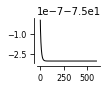

In [14]:
ge.plot(output['t'], output['Vm_soma'])

In [6]:
prox_cond = ntwk.morpho_analysis.find_conditions(SEGMENTS, comp_type=['dend', 'soma'])
np.sum(prox_cond)

3550

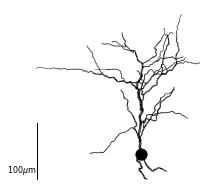

In [10]:
fig, ax = vis.plot_segments(cond=((SEGMENTS['comp_type']=='soma') | (SEGMENTS['comp_type']=='apic')))

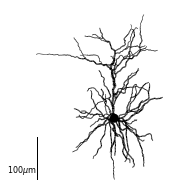

In [12]:
fig, ax = vis.plot_segments(cond=[True if c in ['dend', 'soma', 'apic'] else False\
                                  for c in SEGMENTS['comp_type']])


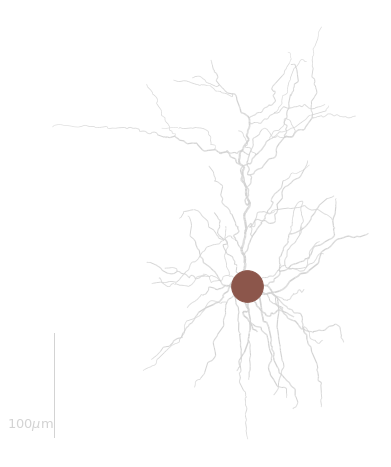

In [13]:
# pre_subset = np.random.choice(pre_to_iseg_Exc, int(Nsyn_Exc/10))

# vis.add_dots(ax, isegs, 5*sizes, 'r')
#vis.add_dots(ax, pre_subset, 10*np.ones(len(pre_subset)), 'r')
#vis.add_circle(ax, [0], [100 ], ge.brown, lw=5)
ax.scatter([0], [0], s=200, c=ge.brown, zorder=100)


Spreading 2442 synapses over the segments


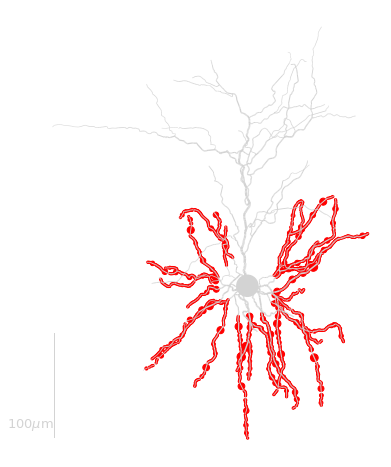

In [9]:
from datavyz import gedn as ge
morpho = ntwk.Morphology.from_swc_file(Model['morpho_file_1'])
SEGMENTS = ntwk.morpho_analysis.compute_segments(morpho)
nseg = len(SEGMENTS['x'])
from datavyz.nrn_morpho import nrnvyz
vis = nrnvyz(SEGMENTS,
             ge=ge)
fig, ax = vis.plot_segments(cond=[True if c in ['dend', 'soma', 'apic'] else False\
                                  for c in SEGMENTS['comp_type']])

def distance(x, y, z):
    return np.sqrt(x**2+y**2+z**2)

cond = (distance(SEGMENTS['x'], SEGMENTS['y'], SEGMENTS['z'])>30e-6) & (SEGMENTS['comp_type']=='dend')
_, N_syn = spread_synapses_on_morpho(SEGMENTS, Model['DensityAMPA'],
                                    cond=cond,
                                    density_factor=1./100./1e-12,
                                    verbose=True)
isegs = np.arange(nseg)[N_syn>0]
sizes = N_syn[N_syn>0]
vis.add_dots(ax, isegs, 5*sizes, 'r')
# for i, n in enumerate(N_syn):
#     vis.add_dot(ax, i, 5*n, 'r')


In [7]:
morpho1 = ntwk.Morphology.from_swc_file(Model['morpho_file_1'])
morpho2 = ntwk.Morphology.from_swc_file(Model['morpho_file_2'])
# fetching all compartments
# COMP_LIST, SEG_INDICES = ntwk.morpho_analysis.get_compartment_list(morpho)
#SEGMENTS = ntwk.morpho_analysis.compute_segments(morpho)

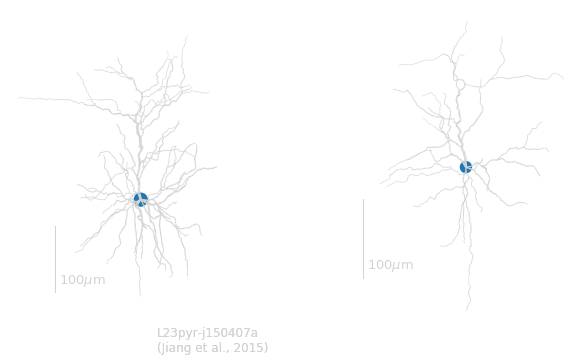

In [23]:
from datavyz import gedn as ge
from datavyz.nrn_morpho import plot_nrn_shape

fig, AX = ge.figure(axes=(2,1),
                    figsize=(1.2,3.), left=0, right=0., top=0., bottom=0.08)

for morpho, ax in zip([morpho1, morpho2], AX):
    SEGMENTS = ntwk.morpho_analysis.compute_segments(morpho)
    plot_nrn_shape(ge, SEGMENTS,
                   comp_type=['dend', 'soma', 'apic'],
                   ax=ax,
                   bar_scale_args=dict(loc=(-130,-140), Ybar=100, Ybar_label=' 100$\mu$m', 
                                   orientation='left-top'))
    ge.annotate(fig, 'L23pyr-j150407a\n(Jiang et al., 2015)', (0.27,0.02), size='small')
#ge.save_on_desktop(fig2)

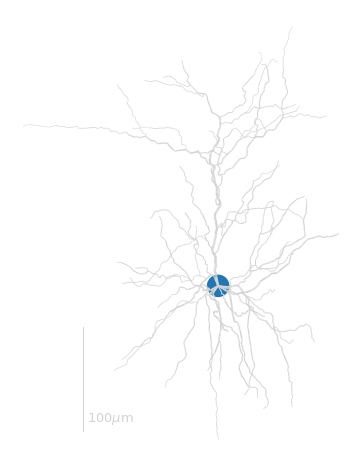

In [20]:
SEGMENTS = ntwk.morpho_analysis.compute_segments(morpho1)
plot_nrn_shape(ge, SEGMENTS,
               comp_type=['dend', 'soma', 'apic'],
               bar_scale_args=dict(loc=(-130,-140), Ybar=100, Ybar_label=' 100$\mu$m', 
                                   orientation='left-top'),
               polar_angle=0, azimuth_angle=6);


# Synaptic model of NMDAR signaling

The time evolution of the NMDA conductance is taken as the combination of four terms: 1) a synaptic waveform, 2) a conductance quantal setting the maximum conductance at full-activation level , 3) a voltage-dependent term (Mg block), 4) a Zn$^{2+}$-inhibition term set as $\big(1 - \alpha_{Zn} \, b_{Zn} \big)$ where $\alpha_{Zn}$ is the fraction of inhibited conductance at maximum Zinc-binding level ($b_{Zn}$=1). This is captured by the equation:

\begin{equation}
g_{NMDA}(V_m, b_{Zn}, t) = N_{Mg}(V_m) \cdot \big(1 - \alpha_{Zn} \, b_{Zn} \big) \cdot Q_{NMDA} \cdot F_{NMDA}(t)
\end{equation}

Following previous modeling work (Ascher and Nowak, 1988; ... ; Farinella et al, 2015; ...; ), the voltage 

Following previous modeling work (Farinella et al, 2015; ...; Ascher and Nowak, 1988), the 


where $F_{NMDA}(t)$ is the temporal waveform of the synaptic event.

, taken as the double exponential waveform: $F_{NMDA} : t \rightarrow A_{NMDA} \cdot (e^{-t/\tau^{decay}_{NMDA}} - e^{-t/\tau^{rise}_{NMDA}} ) $ normalized to its peak-level with the factor $A_{NMDA} = \frac{1}{(\tau^{decay}_{NMDA}/\tau^{rise}_{NMDA}-1} \cdot (\tau^{decay}_{NMDA}/\tau^{rise}_{NMDA})^{\frac{\tau^{decay}_{NMDA}}{\tau^{decay}_{NMDA}-\tau^{rise}_{NMDA}}} $.

\begin{equation}
g^{max}_{NMDA}(V_m, b_{Zn}, t) = Q_{NMDA} \cdot N_{Mg}(V_m) \cdot \big(1 - \alpha_{Zn} \, b_{Zn} \big)
\end{equation}

## Modeling Zinc modulation of NMDAR signaling

We next introduce a biophysical model for the modulation of synaptic transmission due to Zinc binding (illustrated on **Figure Xa**). 


The maximum conductance following a synaptic event is set by the following product: **a)** A conductance quantal setting the maximum conductance at full-activation level , **b)** a voltage-dependent term (Mg block), **c)** a Zn$^{2+}$-inhibition term set as $\big(1 - \alpha_{Zn} \, b_{Zn} \big)$ where $\alpha_{Zn}$ is the fraction of inhibited conductance at maximum binding level ($b_{Zn}$=1).



The bounded-Zinc variable fully describes the phenomenon, without any other underlying dynamics, the temporal dynamics applies to that specific variable. At each synaptic event, Zinc is released and increments the effective-binding variable (bZn), each increment is followed by a decay to model the unbinding dynamics. Here, the on-linearity is model by a state-dependent (bZn-dependent) increment of the bounded-Zn variable (bZn), the higher bZn, the lower the increment (to produce the saturation up to 1).
    
The system of equation for such a model reads:
    
\begin{equation}
\left\{
\begin{split}
\tau^{decay}_{Zn} \cdot \frac{d x}{ dt }  = & - x + \Delta_x ( x )  \sum_{\{t^{k}\}_{glut}} \delta (t-t^k) \\
\tau^{rise}_{Zn} \cdot \frac{d b_{Zn}}{ dt }  = & - b_{Zn} + \mathcal{S}(\frac{x-x_0}{\delta x}) 
\end{split}
\right.
\end{equation}

where $\Delta_x (x)$ is the ($x$-dependent) increment defined by  $\Delta_x : x \rightarrow \Delta_x^0 \cdot \big(1- x \big)$, .

Binding dynamics is implemented by low-pass filtering 

The function $\mathcal{S}$ is the sigmoid function defined by: $\mathcal{S} : X \rightarrow \frac{1}{1+e^{-X}}$, the parameters $x_0$ and $\delta x$ therefore define the center and slope of the sigmoid.

In [9]:
%matplotlib inline
from datavyz import ge
import numpy as np

# Mechanism detail

In [10]:
import numpy as np
from scipy.special import erf
from model import Model

def inactivation_function(c, c0=0., dc=1.):
    """
    inactivation function derived from error function
    """
    return (erf((c-c0)/dc)+1.)/2.

def double_exponential(t, T1, T2):
    """
    double exponential function normalized to peak level
    """
    return (np.exp(-t/T2)-np.exp(-t/T1))/(T2/T1-1)*((T2/T1)**(T2/(T2-T1)))


def compute_time_variations_from_events(SET_OF_EVENTS, t,
                                        Trise=.1e-3, Tdecay=10e-3, quantal=1.):
    """
    integration of synaptic events to shape the synaptic conductance
    (convolution with double exponential over synaptic events)
    """
    conductance = 0*t # initialized to 0

    dt = t[1]-t[0]
    
    ilength = int(5*(Tdecay+Trise)/dt) # for each even we 
    event_waveform = quantal*double_exponential(t[:ilength]-t[0], Trise, Tdecay)
    
    for event in SET_OF_EVENTS:
        i0 = np.argmin((t-event)**2) # find the time point where the event falls
        conductance[i0:min([i0+ilength,len(t)])] += event_waveform[:min([ilength,len(t)-i0])]
        
    return conductance


def compute_pre_from_events(SET_OF_EVENTS, t, delay=0):
    conductance = 0*t # initialized to 0
    for event in SET_OF_EVENTS:
        i0 = np.argmin((t-event-delay)**2) # find the time point where the event falls
        conductance[i0] = 1
    return conductance

def sigmoid(x, x0=0.5, dx=0.1):
    return 1./(np.exp(-(x-x0)/dx)+1)

def sigmoid_deriv(x, dx=0.1):
    return np.exp(-(x-.5)/dx)/dx/(np.exp(-(x-.5)/dx)+1)**2

def voltage_dep_NMDA(x):
    return 1./(0.3+np.exp(-1e3*x*0.08))

def binding_increment(b, b0=0.4):
    return b0*(1-b)

def solve_synapse_equation(t, Model,
                           Glut_events=[],
                           alpha_Zn=0.4,
                           Vm=None):
         
    dt = t[1]-t[0]
    pre_events = compute_pre_from_events(Glut_events, t)
    sim = {'t':t, 
           'Glut_event_trace':pre_events}

    # Ib
    xZn, bZn = 0*t, 0*t
    for i in range(len(t)-1):
        xZn[i+1] = xZn[i]-dt/1e-3/Model['tauDecayZn']*xZn[i]
        bZn[i+1] = bZn[i]+dt/1e-3/Model['tauRiseZn']*(sigmoid(xZn[i],
                                            x0=Model['x0'], dx=Model['deltax'])-bZn[i])
        
        if pre_events[i+1]>0:
            xZn[i+1] += binding_increment(xZn[i+1], b0=Model['Deltax0'])
            #xZn[i+1] += sigmoid_deriv(xZn[i+1], dx=Model['deltax'])*Model['dx_Zn']/sigmoid_deriv(0.5, dx=0.1)
           
    sim['bZn'], sim['xZn'] = bZn, xZn
    
    # NMDA before voltage-dependency and Zinc modulation
    gNMDA = compute_time_variations_from_events(Glut_events, t,
                                                Trise=1e-3*Model['tauRiseNMDA'],
                                                Tdecay=1e-3*Model['tauDecayNMDA'],
                                                quantal=1e-9*Model['qNMDA'])
    
    # modulation function:    
    def NMDA_modulation(Vm, bZn):
        return voltage_dep_NMDA(Vm)*(1.-Model['alphaZn']*bZn)
    
    sim['gNMDA'] = NMDA_modulation(Vm,sim['bZn'])*gNMDA

    return sim

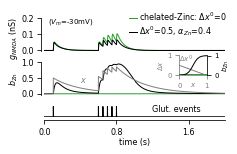

In [11]:
from datavyz import ge#n as ge
t = np.arange(2000)*1e-3
# same events in voltage-clamp -> hyperpolarized

EVENTS = [0.1]+list(np.arange(5)*0.05+.6)

Model['Deltax0'] = 0
sim0 = solve_synapse_equation(t, Model, Glut_events=EVENTS, Vm=-30e-3)
Model['Deltax0'] = 0.5
sim1 = solve_synapse_equation(t, Model, Glut_events=EVENTS, Vm=-30e-3)


fig1, AX = ge.figure(axes_extents=[[[1,2]],
                                  [[1,2]],
                                  [[1,1]]],
                    figsize=(1.7,.25), hspace=1.5, top=3., bottom=3., left=0.5, right=2.)

# model1
ge.plot(t, sim1['Glut_event_trace'], ax=AX[2],
        axes_args={'spines':['bottom'], 'xlabel':'time (s)', 'xlim':[t[0],t[-1]]})
ge.annotate(AX[2], 'Glut. events', (.6, .3))
AX[1].plot(t, 0*t,  lw=1, color=ge.green)
AX[1].plot(t, sim1['bZn'],  lw=1, color='k')
AX[1].plot(t, sim1['xZn'],  lw=1, color='gray')

ge.set_plot(AX[1], ['left'], ylabel='$b_{Zn}$', ylim=[-0.05,1.01], yticks=[0,0.5,1.], xlim=[t[0],t[-1]])

AX[0].plot(t, 1e9*sim0['gNMDA'],  color=ge.green, lw=1, label='chelated-Zinc: $\Delta x^0$=0')
AX[0].plot(t, 1e9*sim1['gNMDA'], color='k', lw=1,
           label='$\Delta x^0$=%.1f, $\\alpha_{Zn}$=%.1f' % (Model['Deltax0'], Model['alphaZn']))
           
ge.set_plot(AX[0], ['left'], ylabel = '$g_{NMDA}$ (nS)    ',
            yticks = [0,.1,.2], xlim=[t[0],t[-1]])

ge.legend(AX[0], loc=(.45,.3), labelspacing=0.2)
ge.annotate(AX[0], '($V_m$=-30mV)', (.02,.75), size='small')


ge.annotate(AX[1], '$x$', (0.2, 0.3), color='gray')

ax = ge.inset(AX[1], [.75,.6,.15,.6])
x = np.linspace(0,1)

ax2 = ax.twinx()
ax2.plot(x, sigmoid(x, dx=Model['deltax']), 'k-', lw=1)
ge.set_plot(ax2, ['right'], size='small', yticks=[0,1],
            ylabel='$b_{Zn}$', xlim=[0,1], ylim=[0,1.01],
            tck_outward=0, ylabelpad=2)

ax.plot(x, Model['Deltax0']*(1-x), 'k-', lw=1, color='gray')
ax.plot(x, 0*x, color=ge.green, lw=2)
ge.annotate(ax, '$\Delta x^0$', (0., Model['Deltax0']), size='small', xycoords='data', color='gray')
ge.set_plot(ax, size='small', xticks=[0,1], yticks=[0,1],
            xlabel='$x$', ylabel='$\Delta x$', xlim=[0,1], ylim=[0,1],
            tck_outward=0, xlabelpad=-8, ylabelpad=2, ycolor='grey', xcolor='grey')


Spreading 915 synapses over the segments


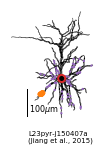

In [31]:
from datavyz import ge
morpho = ntwk.Morphology.from_swc_file(Model['morpho_file_1'])
SEGMENTS = ntwk.morpho_analysis.compute_segments(morpho)
nseg = len(SEGMENTS['x'])

vis = nrnvyz(SEGMENTS, ge=ge)

synapses_loc = 2450+np.arange(10)

fig2, ax = ge.figure(figsize=(1.2,3.), left=0, right=0., top=0., bottom=0.08)
vis.plot_segments(SEGMENTS['comp_type']!='axon',
                  ax=ax, bar_scale_args=dict(loc=(-130,-140), Ybar=100,
                                  Ybar_label=' 100$\mu$m', orientation='left-top'))

basal_cond = ntwk.morpho_analysis.find_conditions(SEGMENTS,
                                                  comp_type='dend',
                                                  min_distance_to_soma=20e-6)
Nsyn, pre_to_iseg,\
        Nsyn_per_seg = ntwk.spread_synapses_on_morpho(SEGMENTS,
                                                      10, # density
                                                      cond=basal_cond,
                                                      density_factor=1./100./1e-12)
vis.add_dots(ax, np.random.choice(pre_to_iseg, 70), 5, ge.purple)

vis.add_dots(ax, synapses_loc, np.ones(len(synapses_loc))*30, ge.orange)
vis.add_circle(ax, 0, 50, ge.red, lw=2)

ge.annotate(fig2, 'L23pyr-j150407a\n(Jiang et al., 2015)', (0.27, 0.02), size='small')
#ge.save_on_desktop(fig2)

In [13]:
from single_cell_sim import initialize_sim, EXC_SYNAPSES_EQUATIONS, ON_EXC_EVENT

def run_demo_sim(Model,
                 Vcmd = -30,
                 t0_stim=100.,
                 freq_pulses=20., # Hz
                 n_pulses=5,
                 tstop=500.,
                 synapses_loc = 2450+np.arange(10)):

    Model['VC-cmd'] = Vcmd
    Model['tstop'] = tstop
    
    # initialize voltage-clamp sim
    t, neuron, SEGMENTS = initialize_sim(Model, method='voltage-clamp')

    spike_IDs, spike_times = np.empty(0, dtype=int), np.empty(0, dtype=float)
    for i in range(n_pulses):
        spike_times = np.concatenate([spike_times,
                                      (t0_stim+i*1e3/freq_pulses)*np.ones(len(synapses_loc))])
        spike_IDs = np.concatenate([spike_IDs,np.arange(len(synapses_loc))])
    
    Estim, ES = ntwk.process_and_connect_event_stimulation(neuron,
                                                           spike_IDs, spike_times,
                                                           synapses_loc,
                                                           EXC_SYNAPSES_EQUATIONS.format(**Model),
                                                           ON_EXC_EVENT.format(**Model))

    # recording and running
    M = ntwk.StateMonitor(neuron, ('v'), record=[0, synapses_loc[0]])
    S = ntwk.StateMonitor(ES, ('X', 'gAMPA', 'gRiseNMDA', 'gDecayNMDA', 'bZn'), record=[0])

    # # Run simulation
    ntwk.run(Model['tstop']*ntwk.ms)

    output = {'t':np.array(M.t/ntwk.ms), 'Vcmd':Vcmd}
    output['Vm_soma'] = np.array(M.v/ntwk.mV)[0,:]
    output['gAMPA_syn'] = np.array(S.gAMPA/ntwk.nS)[0,:]
    output['X_syn'] = np.array(S.X)[0,:]
    bZn, gRise, gDecay = np.array(S.bZn)[0,:], np.array(S.gRiseNMDA)[0,:], np.array(S.gDecayNMDA)[0,:]
    output['Vm_syn'] = np.array(M.v/ntwk.mV)[1,:]
    output['bZn_syn'] = bZn
    output['gNMDA_syn'] = Model['qNMDA']*Model['nNMDA']*(gDecay-gRise)/(1+0.3*np.exp(-output['Vm_syn']/Model['V0NMDA']))*(1.-Model['alphaZn']*bZn)
    output['Ic'] = (output['Vm_soma']-Model['VC-cmd'])*Model['VC-gclamp'] # nA
                                                                        
    return output

output = run_demo_sim(Model)

INFO       No numerical integration method specified for group 'synapses', using method 'euler' (took 0.03s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]


In [14]:
CMD = [-70, -50, -30, -10]

from model import Model
t0, tstop = 100, 500
OUTPUTS_CTRL, OUTPUTS_CHELATED = [], []
from model import Model
ctrl = Model['Deltax0']
for cmd in CMD:
    Model['Deltax0'] = ctrl
    output = run_demo_sim(Model, Vcmd=cmd, t0_stim=t0, tstop=tstop)
    OUTPUTS_CTRL.append(output)
    Model['Deltax0'] = 0
    output = run_demo_sim(Model, Vcmd=cmd)
    OUTPUTS_CHELATED.append(output)
Model['Deltax0'] = ctrl

INFO       No numerical integration method specified for group 'synapses', using method 'euler' (took 0.01s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]


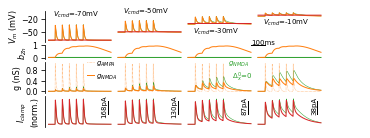

In [15]:
from datavyz import ge
fig3, AX = ge.figure(axes_extents=[[[4,2]],
                                   [[4,1]],
                                   [[4,2]],
                                   [[4,2]]],
                     figsize=(.91,.3), hspace=0.4, right=0.01)

Tspace = 100
DT = tstop-t0
for i, Vcmd, output, output0 in zip(range(len(CMD)), CMD, OUTPUTS_CTRL, OUTPUTS_CHELATED):
    
    cond = output['t']>50
    AX[0].plot(output['t'][cond]+i*(DT+Tspace), output0['Vm_syn'][cond], color=ge.green, lw=0.5)
    AX[0].plot(output['t'][cond]+i*(DT+Tspace), output['Vm_syn'][cond], color=ge.orange, lw=1)
    AX[0].plot(output['t'][cond]+i*(DT+Tspace), output['Vm_soma'][cond], color=ge.red, lw=1)
    AX[1].plot(output['t'][cond]+i*(DT+Tspace), output0['bZn_syn'][cond], color=ge.green, lw=1)
    AX[1].plot(output['t'][cond]+i*(DT+Tspace), output['bZn_syn'][cond], color=ge.orange, lw=1)
    AX[2].plot(output['t'][cond]+i*(DT+Tspace), output0['gNMDA_syn'][cond], color=ge.green, lw=0.5)
    if i==0:
        AX[2].plot(output['t'][cond]+i*(DT+Tspace), output['gAMPA_syn'][cond], ':', color=ge.orange, lw=.5, label='$g_{AMPA}$')
        # AX[2].plot(output['t'][cond]+i*(DT+Tspace), output0['gNMDA_syn'][cond], color=ge.green, lw=0.5, label='$g_{NMDA}$, $\Delta_x^0$=0')
        AX[2].plot(output['t'][cond]+i*(DT+Tspace), output['gNMDA_syn'][cond], color=ge.orange, label='$g_{NMDA}$', lw=1)
    else:
        AX[2].plot(output['t'][cond]+i*(DT+Tspace), output['gAMPA_syn'][cond], ':', color=ge.orange, lw=.5)
        AX[2].plot(output['t'][cond]+i*(DT+Tspace), output['gNMDA_syn'][cond], color=ge.orange, lw=1)
    # AX[3].plot(output['t'][cond]+i*(DT+Tspace), 1e3*(output0['Ic'][cond]-output0['Ic'][cond][0]), color=ge.green)
    norm = (np.max(output0['Ic'][cond])-np.min(output0['Ic'][cond]))
    dI2 = 1/norm*(output0['Ic'][cond]-np.min(output0['Ic'][cond]))
    AX[3].plot(output['t'][cond]+i*(DT+Tspace), dI2, color=ge.green, lw=0.5)
    dI = 1/norm*(output['Ic'][cond]-np.min(output['Ic'][cond]))
    AX[3].plot(output['t'][cond]+i*(DT+Tspace), dI, color=ge.red, lw=1)
    AX[3].plot(np.ones(2)*(output['t'][-1]+i*(DT+Tspace)-Tspace/4), (.4, .9), 'k-', lw=1)    
    ge.annotate(AX[3], '%ipA' % (1e3*.5*norm), (output['t'][-1]+i*(DT+Tspace)-Tspace/4,.73), xycoords='data',
                rotation=90, ha='right', size='small', va='center')

ge.legend(AX[2], loc=(.115,.3), size='small')
ge.annotate(AX[2], '$g_{NMDA}$\n  $\Delta_x^0$=0', (.57,.3), color=ge.green, size='small')
for i, Vcmd, y in zip(range(len(CMD)), CMD, [-20,-15,-60,-40]):
    ge.annotate(AX[0], '$V_{cmd}$=%imV' % Vcmd, (i*(DT+Tspace)+(DT+Tspace)/2., y), xycoords='data', ha='center', size='small')

ge.annotate(AX[1], '100ms', (1500,1.01), xycoords='data', size='small')
AX[1].plot(1500+np.arange(2)*100, np.ones(2), 'k-', lw=1)    

ge.set_plot(AX[0], ['left'], ylabel='$V_m$ (mV)', yticks=[-50,-20],
            xlim=[output['t'][cond][0],output['t'][-1]+i*600])
ge.set_plot(AX[1], ['left'], ylabel='$b_{Zn}$', yticks=[0,1], ylim=[-0.1, 1.01], ylabelpad=4,
            xlim=[output['t'][cond][0],output['t'][-1]+i*600])
ge.set_plot(AX[2], ['left'], ylabel='g (nS)', ylabelpad=3,
            xlim=[output['t'][cond][0],output['t'][-1]+i*600])
ge.set_plot(AX[3], ['left'], ylabel='$I_{clamp}$\n(norm.)',
            yticks=[], ylim=[-0.1,1.1], ylabelpad=6,
            xlim=[output['t'][cond][0],output['t'][-1]+i*600])

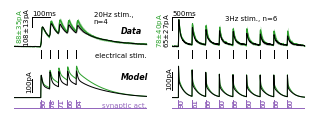

In [4]:
from analyz.IO.npz import load_dict
from datavyz import ge
import numpy as np

sb = 100 # subsampling of exp data

MDATA = load_dict('data/model-after-calib.npz')
FDATA = load_dict('data/full_data_for_calibration.npz')

fig4, AX = ge.figure(axes_extents=[[[1,7],[1,7]],
                                   [[1,2],[1,2]],
                                   [[1,1],[1,1]],
                                   [[1,7],[1,7]],
                                   [[1,2],[1,2]]],
                     figsize=(1.48,0.11),
                     wspace=0.3, hspace=0, right=0., left=0.2)

for ax in AX[2]:
    ax.axis('off')
    
for cond, ax, ax1, ax2, ax3, I0, t0, DI, T in zip(['20Hz_condition', '3Hz_condition'],
                                                  AX[0], AX[1], AX[3], AX[4], [1.5, 1.1],
                                        [100, 0], [0.5, 0.5], [100, 500]):

    ## exp
    ax.plot(FDATA[cond]['t'][0]+t0+np.zeros(2), [I0,I0-DI], lw=1, color=ge.default_color)
    ax.plot(FDATA[cond]['t'][0]+t0+np.arange(2)*T, [I0, I0], lw=1, color=ge.default_color)
    ge.annotate(ax, '%.0f$\pm$%.0fpA' % (1e3*FDATA[cond]['scale_ctrl'].mean()*DI,
                1e3*FDATA[cond]['scale_ctrl'].std()*DI),
                (FDATA[cond]['t'][0]+t0, I0-DI), xycoords='data', rotation=90,
                ha='right', va='center', size='small')
    ge.annotate(ax, '%.0f$\pm$%.0fpA\n' % (1e3*FDATA[cond]['scale_test'].mean()*DI,
                1e3*FDATA[cond]['scale_test'].std()*DI),
                (FDATA[cond]['t'][0]+t0, I0-DI), xycoords='data', rotation=90,
                ha='right', color=ge.green, va='center', size='small')
    ge.plot(FDATA[cond]['t'][::sb], FDATA[cond]['norm_trace_test'].mean(axis=0)[::sb],
            sy=FDATA[cond]['norm_trace_test'].std(axis=0)[::sb], ax=ax, color=ge.green)
    ge.plot(FDATA[cond]['t'][::sb], FDATA[cond]['norm_trace_test'].mean(axis=0)[::sb],
            sy=FDATA[cond]['norm_trace_test'].std(axis=0)[::sb], ax=ax, color=ge.green)
    ge.plot(FDATA[cond]['t'][::sb], FDATA[cond]['norm_trace_ctrl'].mean(axis=0)[::sb],
            sy=FDATA[cond]['norm_trace_ctrl'].std(axis=0)[::sb], ax=ax)
    ge.annotate(ax, '%ims' % T, (FDATA[cond]['t'][0]+t0, I0), xycoords='data', size='small')
    ge.set_plot(ax,[], xlim=[FDATA[cond]['t'][0], FDATA[cond]['t'][-1]])

    ## model
    DT0 = FDATA[cond]['t'][FDATA[cond]['se'][0]]-FDATA[cond]['t'][0]
    DTfull = FDATA[cond]['t'][-1]-FDATA[cond]['t'][0]

    YSCALE = 100
    stim = MDATA['free']
    tcond = (stim['t']>(stim['%s_tstart' % cond]-DT0)) &\
        (stim['t']<(stim['%s_tstart' % cond]-DT0+DTfull))
    for output, c in zip([MDATA['chelated'], MDATA['free']], [ge.green, ge.default_color]):
        trace = output['Ic'][tcond]-output['Ic'][tcond][0]
        tt = output['t'][tcond]
        ax2.plot(tt, 1e3*trace, color=c, lw=1)
        
    ax2.plot(output['t'][tcond][0]+t0+np.zeros(2), [.4*YSCALE, 1.4*YSCALE], lw=1, color=ge.default_color)
    ge.annotate(ax2, '%ipA' % YSCALE, (output['t'][tcond][0]+t0, .4*YSCALE), xycoords='data', rotation=90, ha='right', va='bottom', size='small')
        
    ge.set_plot(ax2,[], xlim=[output['t'][tcond][0], output['t'][tcond][-1]])

    
    x, y = [output['t'][tcond][0]], [0]
    for e, n in zip(output['events'], output['Npicked']):
        x += [e,e,e]
        y += [0,1,0]
        if e>=stim['3Hz_condition_tstart']:
            ge.annotate(AX[4][1], str(n), (e, 0.1), size='small', xycoords='data',
                        rotation=90, color=ge.purple)
        else:
            ge.annotate(AX[4][0], str(n), (e, 0.1), size='small', xycoords='data',
                        rotation=90, color=ge.purple)
    x += [output['t'][tcond][-1]]
    y += [0]
    x, y = np.array(x), np.array(y)
    tcond = (x>=output['t'][tcond][0]) & (x<=output['t'][tcond][-1])
    ax1.plot(x[tcond], y[tcond], 'k-', lw=1)
    ax3.plot(x[tcond], y[tcond], lw=1, color=ge.purple)
    ge.set_plot(ax1,[], xlim=[x[tcond][0],x[tcond][-1]], ylim=[-.1,1.1])
    ge.set_plot(ax3,[], xlim=[x[tcond][0],x[tcond][-1]], ylim=[-.1,1.1])
ge.annotate(AX[0][0], '20Hz stim.,\nn=%i' % len(FDATA['20Hz_condition']['norm_trace_ctrl']),
            (.6,.7), size='small')
ge.annotate(AX[0][1], '3Hz stim., n=%i' % len(FDATA['3Hz_condition']['norm_trace_ctrl']),
            (.4,.8), size='small')

ge.annotate(AX[0][0], 'Data', (.8,.4), italic=True, bold=True)
ge.annotate(AX[3][0], 'Model', (.8,.5), italic=True, bold=True)
ge.annotate(AX[1][0], 'electrical stim.', (1.,.1), ha='right', size='small')
ge.annotate(AX[4][0], 'synaptic act.', (1.,.1), ha='right', size='small', color=ge.purple)


In [104]:
ge.multipanel_figure([[fig1, fig2], [fig3], [fig4]],
                     LABELS=[['a','b'], ['c'], ['d']],
                     Y_LABELS = [[0,0],[135],[275]],
                     X=[[0,230], [0], [0], [20]],
                     Y=[[0,-8], [145], [285]],
                     width='one-and-a-half-column',
                     height=140, #grid=True,
                     fig_name='figures/fig-model-description.png')

RUNNING: inkscape figures/fig-model-description.svg --export-area-page --export-background="white" --export-type=png --export-filename="figures/fig-model-description.png" --export-dpi=300
[ok] figure successfully exported as: figures/fig-model-description.png
[ok] removed figures/fig-model-description.svg


# Modeling Zinc modulation of NMDAR signaling

Model ingredients:

- Zinc inhibits NMDAR via a high-affinity binding mechanism
- NMDAR has its classical voltage dependency 
- Zinc inhibition is concentration dependent (with a half activation value in the nanomolar range) and voltage-independent
- Zinc is stored in synaptic vesicles and co-released with glutamate
- Zinc concentration in the synaptic cleft follows a release/re-uptake dynamics
- Zinc effect on NMDAR has a binding/unbinding dynamics

## Modeling Zinc modulation in a single compartment

In a single compartment model containing AMPA, NMDA and GABA synaptic currents, the membrane equation reads:

\begin{equation}
\label{eq:membrane-eq-single-comp}
\begin{split}
C_m \frac{dV_m}{dt} = & g_L \, \big(E_L - V_m \big) \\
                      + & g_{NMDA}(V_m, b_{Zn}, t) \, (E_{NMDA}-V_m) \\
                      + & g_{AMPA}(t)  \, (E_{AMPA}-V_m) \\
                      + & g_{GABA}(t)  \, (E_{GABA}-V_m)
\end{split}
\end{equation}

The AMPA and GABA synaptic currents depend on the conductances ($g_{AMPA}$ and $g_{GABA}$ respectively), they are voltage independent, their temporal dynamics are only constrained by the integration of synaptic events, i.e. they and follow the equations:

\begin{equation}
g_{AMPA}(t) =  Q_{AMPA} \, \sum_{\{t^{k}\}_{glut}} \mathcal{H}(t-t^k) \cdot B(t-t^k, \tau_{AMPA}^{rise}, \tau_{AMPA}^{decay})
\end{equation}

\begin{equation}
g_{GABA}(t) =  Q_{GABA} \, \sum_{\{t^{k}\}_{GABA}} \mathcal{H}(t-t^k) \cdot  B(t-t^k, \tau_{GABA}^{rise}, \tau_{GABA}^{decay})
\end{equation}

where:
\begin{equation}
B (t, \tau_1, \tau_2) = \frac{(\tau_2/\tau_1)^{\frac{\tau_2}{\tau_2-\tau_1}}}{\tau_2/\tau_1 -1 } \Big( e^{-t/\tau_2} - e^{-t/\tau_1} \Big)
\end{equation}
is the normalized double exponential function (peaking to 1 at maximum), where $Q_{AMPA}$ and $Q_{GABA}$ are the quantals of conductance increments at their respective events, and where $\{t^{k}\}_{glut}$ and $\{t^{k}\}_{GABA}$ are respectively the sets of glutamatergic and GABAergic presynaptic events.

In addition to its dependency on the set of glutamatergic synaptic events, the NMDA conductance has both a dependency on membrane depolarization ($V_m$) and on the Zinc-concentration ($c_{Zn}$), its equation is:

\begin{equation}
g_{NMDA}(V_m, c_{Zn}, t) = N(V_m) \cdot \big(1 - \alpha_{Zn} \, F(c_{Zn}) \big) \cdot Q_{NMDA} \, \sum_{\{t^{k}\}_{glut}}  \mathcal{H}(t-t^k) \cdot B(t-t^k, \tau_{NMDA}^{rise}, \tau_{NMDA}^{decay})
\end{equation}

where $N(V_m)$ is the classical voltage-dependency of NMDA channels due to the Magnesium block described by (Farinella et al., 2014):

\begin{equation}
N(V_m) = \frac{1}{0.3+e^{- 80 * V_m} }
\end{equation}

where $\alpha_{Zn}$ is the fraction of inactivated NMDA channel at maximum inactivation (i.e. at high Zinc concentration), where $Q_{NMDA}$ is the quantal of (maximum) conductance increment and where $F(c_{Zn})$ is the relation between "effective" Zinc concentration and NMDA inactivation, this inactivation function is determined by the error function:

\begin{equation}
F(c_{Zn}) = (1+ Erf\big( \frac{c-c^0_{Zn}}{\delta c_{Zn}} \big))/2
\end{equation}

The temporal evolution of the "effective" Zinc concentration in the synaptic cleft is also determined by the set of glutametargic events with:
\begin{equation}
c_{Zn}(t) = Q_{Zn} \, \sum_{\{t^{k}\}_{glut}} \mathcal{H}(t-t^k) \cdot B(t-t^k, \tau_{Zn}^{rise}, \tau_{Zn}^{decay})
\end{equation}

----------------------------------------------

$Zn^{2+}$ chelation is modelled by $Q_{Zn}=0$ (the glutamate release does not lead to any increase of the "effective" Znc concentration), 

it could also be modelled by $\alpha_{Zn}$=0 (the variations of Zinc concentrations do not have any effect)

----------------------------------------------

TO BE DISCUSSED / SHAKY ASPECTS

- the Binding/Unbinding dynamics and the Release/Re-uptake dynamics are merged into a single "effective" Zinc dynamics for simplicity

- the Zinc concentration is a linear variable spanning [0,100nM], we could have it logarhitmically spanning [1nM, 1uM]


## Parameters

In [1]:
# all parameters in SI units ! (i.e. volts, amps, siemens, seconds, ...)

params = {
    # passive cellular properties
    'Cm':200e-12, # farad
    'gL':10e-9, # siemens
    'El':-70e-3, # volt
    # GABA
    'Trise_GABA':0.5e-3, # second
    'Tdecay_GABA':5e-3,
    'Q_GABA':1e-9,
    'Erev_GABA':-80e-3,
    # AMPA
    'Trise_AMPA':0.5e-3,
    'Tdecay_AMPA':5e-3,
    'Q_AMPA':1e-9,
    'Erev_AMPA':0e-3,
    # NMDA
    'NMDA-to-AMPA-ratio':0.8,
    'Trise_NMDA':7e-3,
    'Tdecay_NMDA':70e-3,
    'Q_NMDA':0.8e-9, # i.e. from 'NMDA-to-AMPA-ratio':0.8,
    'Erev_NMDA':0e-3,
    # Vm-modul NMDA
    'V0_NMDA':1./0.08,
    # Zn-modul NMDA
    'Q_Zn':5e-9, # increment of effective Zn concentration
    'C0_Zn':20e-9,
    'deltaC_Zn':10e-9,
    'Trise_Zn':15e-3,
    'Tdecay_Zn':0.3,
    'alpha_Zn':0.4, # fraction of inactivated conductance at peak 
}

params_no_Zn = params.copy() 
params_no_Zn['Q_Zn'] = 0

## Numerical implementation

In [1]:
import numpy as np
from scipy.special import erf

def inactivation_function(c, c0=0., dc=1.):
    """
    inactivation function derived from error function
    """
    return (erf((c-c0)/dc)+1.)/2.

def double_exponential(t, T1, T2):
    """
    double exponential function normalized to peak level
    """
    return (np.exp(-t/T2)-np.exp(-t/T1))/(T2/T1-1)*((T2/T1)**(T2/(T2-T1)))


def compute_time_variations_from_events(SET_OF_EVENTS, t,
                                        Trise=1e-3, Tdecay=10e-3, quantal=1.):
    """
    integration of synaptic events to shape the synaptic conductance
    (convolution with double exponential over synaptic events)
    """
    conductance = 0*t # initialized to 0

    dt = t[1]-t[0]
    ilength = int(5*(Tdecay+Trise)/dt) # for each even we 
    event_waveform = quantal*double_exponential(t[:ilength]-t[0], Trise, Tdecay)
    
    for event in SET_OF_EVENTS:
        i0 = np.argmin((t-event)**2) # find the time point where the event falls
        conductance[i0:min([i0+ilength,len(t)])] += event_waveform[:min([ilength,len(t)-i0])]
        
    return conductance

def compute_pre_from_events(SET_OF_EVENTS, t):
    conductance = 0*t # initialized to 0
    for event in SET_OF_EVENTS:
        i0 = np.argmin((t-event)**2) # find the time point where the event falls
        conductance[i0] = 1
    return conductance

def voltage_dep_NMDA(x):
    """
    x should be in volts !!
    
    taken from Farinella et al. (2014)
    """
    return 1./(0.3+np.exp(-1e3*x*0.08))

def binding_increment(b, b0=0.4):
    return b0*(1-b)


def plot_temporal_dynamics(simulation, ge):
    """
    a general plotting function to visualize the result of a simulation 
        over the different variables of the model
    """
    fig, AX = ge.figure(axes_extents=[[[3,2]],[[3,1]],[[3,1]],[[3,1]],[[3,1]]], figsize=(1.3,.5))

    if simulation['result_type']=='current-clamp':
        AX[0].plot(1e3*simulation['t'], 1e3*simulation['Vm'], 'k-')
        ylabel1 = '$V_m$ (mV)'
    elif simulation['result_type']=='voltage-clamp':
        AX[0].plot(1e3*simulation['t'], 1e12*simulation['Itot'], 'k-')
        ylabel1 = '$I_{tot}$ (pA)'
       
    AX[1].plot(1e3*simulation['t'], 1e9*simulation['gGABA'], color=ge.red)
    AX[2].plot(1e3*simulation['t'], 1e9*simulation['gAMPA'], color=ge.green)
    AX[3].plot(1e3*simulation['t'], 1e9*simulation['gNMDA'], color=ge.blue)
    AX[4].plot(1e3*simulation['t'], 1e9*simulation['cZn'], color=ge.purple)
    for ax, label, i in zip(np.array(AX).flatten(),\
          [ylabel1, '$g_{GABA}$ (nS)', '$g_{AMPA}$ (nS)', '$g_{NMDA}$ (nS)', '$c_{Zn}$ (nM)'],
                           range(5)):
        ge.set_plot(ax, ['left', 'bottom'][:int(i/4)+1], ylabel=label,
                    xlim=[1e3*simulation['t'][0], 1e3*simulation['t'][-1]])
    AX[4].set_xlabel('time (ms)')
    
    return fig, AX


def solve_membrane_equation(t, params,
                            Glut_events=[],
                            GABA_events=[],
                            Vm=None,
                            result_type='current-clamp'):
    """
    solve the membrane equation
    2 result type:
        --> current-clamp
        --> voltage-clamp: the Vm array should have the clamp values (no Rs considered)
    """
        
    dt = t[1]-t[0]
    sim = {'t':t, 'result_type':result_type} # we store all results into a python dictionary

    Glut_event_trace = compute_pre_from_events(Glut_events, t)
    sim['Glut_event_trace'] = pre_event_trace

    sim['gGABA'] = compute_time_variations_from_events(GABA_events, t,
                        Trise=params['Trise_GABA'], Tdecay=params['Tdecay_GABA'], quantal=params['Q_GABA'])
    sim['gAMPA'] = compute_time_variations_from_events(Glut_events, t,
                        Trise=params['Trise_AMPA'], Tdecay=params['Tdecay_AMPA'], quantal=params['Q_AMPA'])
    sim['cZn'] = compute_time_variations_from_events(Glut_events, t,
                        Trise=params['Trise_Zn'], Tdecay=params['Tdecay_Zn'], quantal=params['Q_Zn'])
    
    # NMDA before voltage-dependency and Zinc modulation
    gNMDA = compute_time_variations_from_events(Glut_events, t,
                    Trise=params['Trise_NMDA'], Tdecay=params['Tdecay_NMDA'], quantal=params['Q_NMDA'])
    # modulation function:    
    def NMDA_modulation(Vm, cZn):
        return voltage_dep_NMDA(Vm)*\
            (1-params['alpha_Zn']*inactivation_function(cZn,
                                                        c0=params['C0_Zn'], dc=params['deltaC_Zn']))
    
    def Itot(Vm, gA, gB, gN, cZn):
        return params['gL']*(params['El']-Vm)+\
               gA*(params['Erev_AMPA']-Vm)+\
               NMDA_modulation(Vm,cZn)*gN*(params['Erev_NMDA']-Vm)+\
               gB*(params['Erev_GABA']-Vm)
    
    # initialize Vm (if not already provided as an array in the argument)
    if Vm is None:
        Vm = 0*t+params['El'] # initialize to rest 
    elif type(Vm) is float:
        Vm = 0*t+Vm
    
    if result_type=='current-clamp':
        # need to solve the membrane equation with an euler method
        for i in range(len(t)-1):
            Vm[i+1] = Vm[i]+dt/params['Cm']*Itot(Vm[i],
                                                 sim['gAMPA'][i], sim['gGABA'][i], gNMDA[i], sim['cZn'][i])
    elif result_type=='voltage-clamp':
        # nothing to do, we just return the total current over time given the voltage array
        pass
    else:
        print('Result type need to be set to either voltage-clamp or dynamic clamp')
        
    sim['Vm'] = Vm
    sim['Itot'] = -Itot(Vm, sim['gAMPA'], sim['gGABA'], gNMDA, sim['cZn']) # sign reversed (amplifier convention)
    sim['gNMDA'] = NMDA_modulation(Vm,sim['cZn'])*gNMDA

    return sim

## Checking the numerical implementation

In [7]:
from datavyz import gen as ge

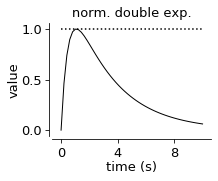

In [21]:
import numpy as np
# double exponential waveform
t = np.linspace(0,10)
_, ax = ge.plot(t, double_exponential(t, .5, 3.), title='double exponential\n normalized waveform',
                axes_args=dict(xlabel='time (s)', ylabel='value', yticks=[0,0.5,1],title='norm. double exp.'))
ax.plot(t, np.ones(len(t)), 'k:')

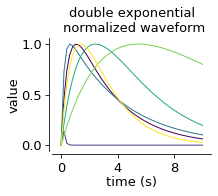

In [22]:
# showing the normalization
_, ax = ge.plot(t,
                Y=[double_exponential(t, .5, 3.),
                   double_exponential(t, .001, .1),
                   double_exponential(t, .2, 4.),
                   double_exponential(t, 3, 2),
                   double_exponential(t, 5, 6.),
                   double_exponential(t, 1, 2)],
                title='double exponential\n normalized waveform',
                axes_args=dict(xlabel='time (s)', ylabel='value', yticks=[0,0.5,1]));

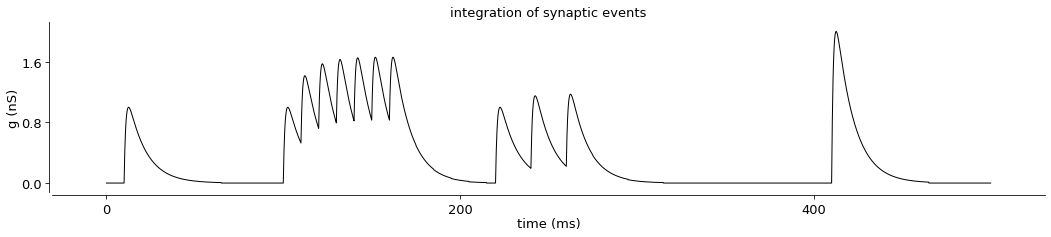

In [23]:
# conductance traces with time parameters
dt, tstop = 0.1, 500 # in ms
t = np.arange(int(tstop/dt))*dt

# generated by a set of events:
SET_OF_EVENTS = [10, 100, 110, 120, 130, 140, 150, 160, 220, 240, 260, 410, 410] # ms, N.B. double events !
conductance = compute_time_variations_from_events(SET_OF_EVENTS, t,
                                              Trise=1, Tdecay=10, # also in ms
                                              quantal=1.) # 1nS peak increment at each event 

ge.plot(t, conductance,
        title='integration of synaptic events', fig_args={'figsize':(2.5,1.5)},
        axes_args=dict(xlabel='time (ms)', ylabel='g (nS)'));

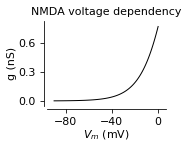

In [8]:
# Voltage dependency of NMDA current

Vm= np.linspace(-90e-3,0e-3,100) 

fig, ax = ge.plot(1e3*Vm, voltage_dep_NMDA(Vm),
                    title='NMDA voltage dependency')
ge.set_plot(ax, xlabel='$V_m$ (mV)', ylabel='g (nS)')

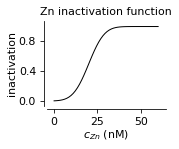

In [9]:
# Inactivation function of Zinc effect

c = np.linspace(0,60e-9)

fig, ax = ge.plot(1e9*c, inactivation_function(c, c0=params['C0_Zn'], dc=params['deltaC_Zn']),
                    title='Zn inactivation function')
ge.set_plot(ax, xlabel='$c_{Zn}$ (nM)', ylabel='inactivation')

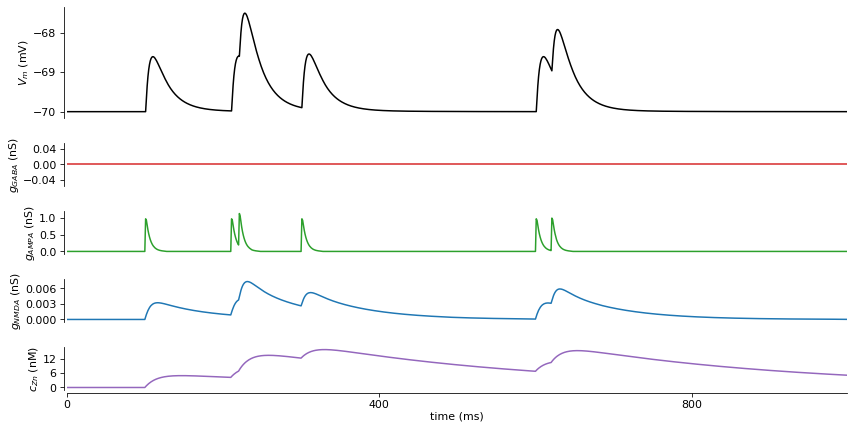

In [10]:
# temporal dynamics of the model current clamp

sim = solve_membrane_equation(np.arange(1000)*1e-3, params,
                              Glut_events=[0.1, 0.21, 0.22, 0.3, 0.6, 0.62],
                              result_type='current-clamp')
plot_temporal_dynamics(sim, ge);

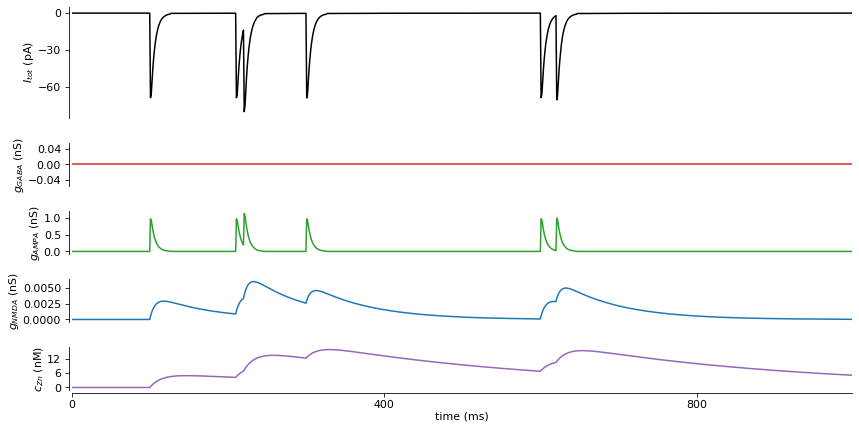

In [11]:
# same events in voltage-clamp -> hyperpolarized
sim = solve_membrane_equation(np.arange(1000)*1e-3, params,
                              Glut_events=[0.1, 0.21, 0.22, 0.3, 0.6, 0.62],
                              Vm = -70e-3,
                              result_type='voltage-clamp')
plot_temporal_dynamics(sim, ge);

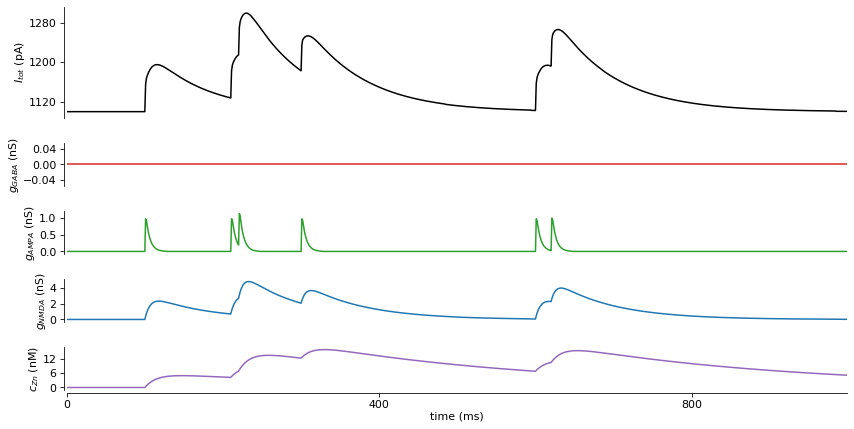

In [12]:
# same events in voltage-clamp -> highly depolarized (+40 mV)
sim = solve_membrane_equation(np.arange(1000)*1e-3, params,
                              Glut_events=[0.1, 0.21, 0.22, 0.3, 0.6, 0.62],
                              Vm = + 40e-3,
                              result_type='voltage-clamp')
plot_temporal_dynamics(sim, ge);

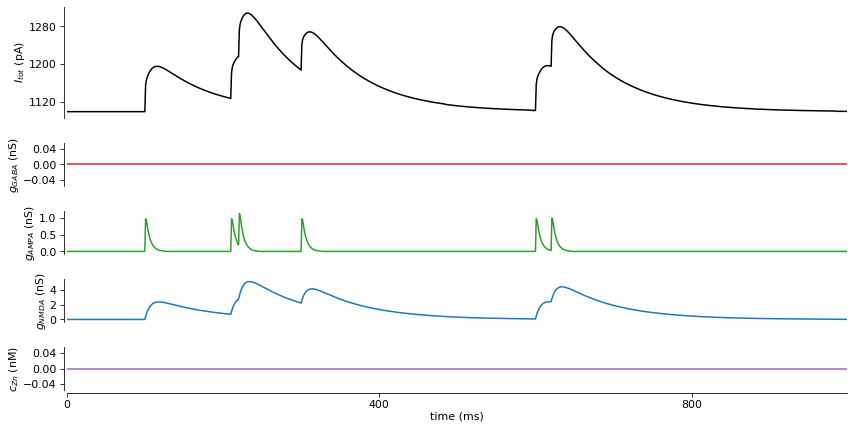

In [13]:
# same events in voltage-clamp -> highly depolarized (+40 mV)
sim_no_Zn = solve_membrane_equation(np.arange(1000)*1e-3, params_no_Zn,
                              Glut_events=[0.1, 0.21, 0.22, 0.3, 0.6, 0.62],
                              Vm = + 40e-3,
                              result_type='voltage-clamp')
plot_temporal_dynamics(sim_no_Zn, ge); # note the increase of the last events

## Response to pulse trains

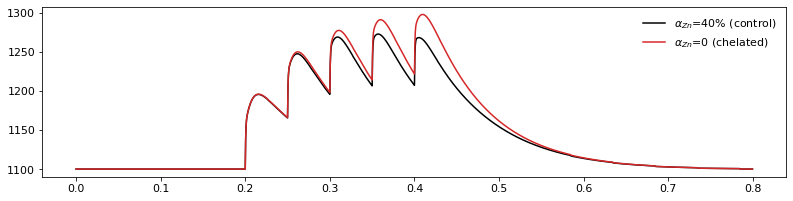

In [14]:
# protocol setup
tstop, dt = 800e-3, 5e-4
t = np.arange(int(tstop/dt))*dt
SET_OF_EVENTS = [200e-3, 250e-3, 300e-3, 350e-3, 400e-3] # 5 pulses at 20Hz freq
# with Zinc modulation
sim = solve_membrane_equation(t, params, Glut_events=SET_OF_EVENTS,
                              Vm = + 40e-3,
                              result_type='voltage-clamp')

# without Zinc modulation
sim_no_Zn = solve_membrane_equation(t, params_no_Zn, Glut_events=SET_OF_EVENTS,
                              Vm = + 40e-3,
                              result_type='voltage-clamp')

_, ax = ge.figure(figsize=(2.5,2))
ax.plot(t, 1e12*sim['Itot'], color='k', label=r'$\alpha_{Zn}$=40% (control)')
ax.plot(t, 1e12*sim_no_Zn['Itot'], color=ge.red, label=r'$\alpha_{Zn}$=0 (chelated)')
ax.legend(frameon=False)

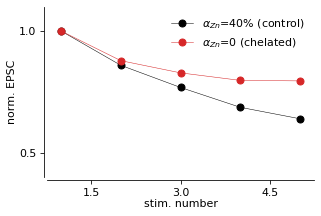

In [15]:
# from the above simulations, normalized EPSCs analysis
_, ax = ge.figure(figsize=(1.5,2))
STIM_NUMBER = range(1, len(SET_OF_EVENTS)+1)
# we look for the peak current in between two stimulation events
for simulation, c, condition in zip([sim, sim_no_Zn],
                                    ['k', ge.red],                                   
                                [r'$\alpha_{Zn}$=40% (control)', r'$\alpha_{Zn}$=0 (chelated)']):
    nEPSCS = []
    for t1, t2 in zip(SET_OF_EVENTS, SET_OF_EVENTS[1:]+[t[-1]]):
        I0 = simulation['Itot'][int(t1/dt)] # current reight before new event as baseline
        IMAX = simulation['Itot'][int(t1/dt):int(t2/dt)].max() # max in between two events
        nEPSCS.append(IMAX-I0) # EPSCs are the difference
        
    ax.plot(STIM_NUMBER, np.array(nEPSCS)/nEPSCS[0], 'o-', color=c, label=condition, lw=.5, ms=7)
ax.legend(frameon=False)
ge.set_plot(ax, xlabel='stim. number', ylabel='norm. EPSC', ylim=[0.4,1.1], yticks=[0.5,1])  